In [ ]:
# 참고 : https://github.com/kairess/colorizer

In [ ]:
# 내 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2 # opencv 3.4.2+ required
import os
import numpy as np
import matplotlib.pyplot as plt

# Prepare Model


In [ ]:
!mkdir models
%cd models
!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2_norebal.caffemodel

/content/models
--2021-05-13 07:19:49--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2021-05-13 07:19:50--  https://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2021-05-13 07:19:50--  https://people.eecs.berkeley.edu/~ri

In [ ]:
%cd ..
%ls
!git clone https://github.com/alexellis/faas-colorization.git

!cp faas-colorization/function/models/colorization_deploy_v2.prototxt models/
!cp faas-colorization/function/resources/pts_in_hull.npy models/

# models 폴더에 있는 내용을 내 구글 드라이브로 복사
!cp -r ./models /content/gdrive/MyDrive/CV2/colorize/

!git clone https://github.com/kairess/colorizer.git

# VM에 있는 /colorizer/img 폴더를 있는 내용을 내 구글 드라이브로 복사
!cp -r ./colorizer/img /content/gdrive/MyDrive/CV2/colorize/

/content
gdrive/  models/  sample_data/
Cloning into 'faas-colorization'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 7.15 MiB | 9.14 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Cloning into 'colorizer'...
remote: Enumerating objects: 94, done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 94
Unpacking objects: 100% (94/94), done.


In [ ]:
proto = './models/colorization_deploy_v2.prototxt'
weights = './models/colorization_release_v2.caffemodel'
# colorization_release_v2_norebal.caffemodel is trained with a classification loss with no class re-balancing term.
# The results are duller but "safer" colorizations
# weights = './models/colorization_release_v2_norebal.caffemodel' 

# load cluster centers
pts_in_hull = np.load('./models/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)

# load model
net = cv2.dnn.readNetFromCaffe(proto, weights)
# net.getLayerNames()

# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
# scale layer doesn't look work in OpenCV dnn module, we need to fill 2.606 to conv8_313_rh layer manually
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

# Preprocessing

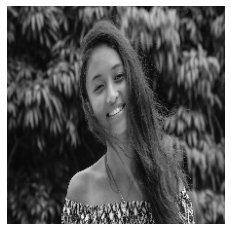

In [ ]:
img_path = '/content/gdrive/MyDrive/CV2/colorize/img/sample_6.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_input = img.copy()

# convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

img_rgb = img.copy()

# normalize input
img_rgb = (img_rgb / 255.).astype(np.float32)

# convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
# only L channel to be used
img_l = img_lab[:, :, 0]

input_img = cv2.resize(img_l, (224, 224))
input_img -= 50 # subtract 50 for mean-centering

# plot images
# fig = plt.figure(figsize=(10, 5))
# fig.add_subplot(1, 2, 1)
# plt.imshow(img_rgb)
# fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(input_img, cmap='gray')

# Prediction

True

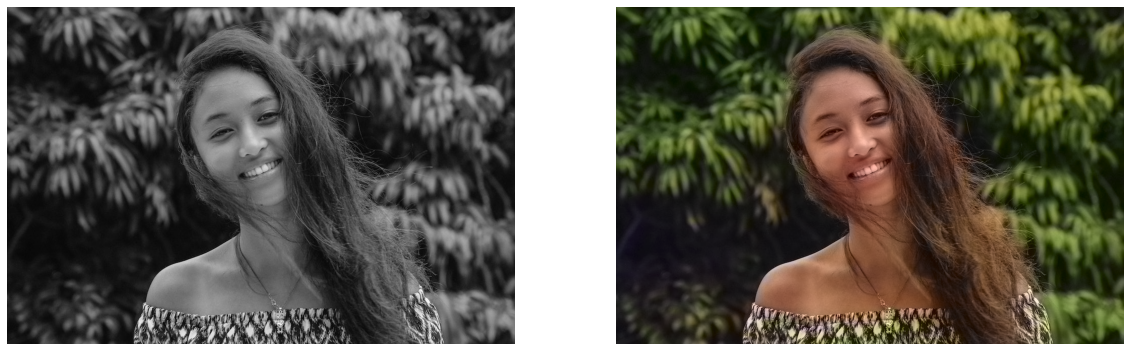

In [ ]:
net.setInput(cv2.dnn.blobFromImage(input_img))
pred = net.forward()[0,:,:,:].transpose((1, 2, 0))

# resize to original image shape
pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0]))

# concatenate with original image L
pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2)

# convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255
pred_rgb = pred_rgb.astype(np.uint8)

# plot prediction result
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).axis('off')
plt.imshow(img_l, cmap='gray')
fig.add_subplot(1, 2, 2).axis('off')
plt.imshow(pred_rgb)
# plt.savefig(output_filename)

# save result image file
filename, ext = os.path.splitext(img_path)
input_filename = '%s_input%s' % (filename, ext)
output_filename = '%s_output%s' % (filename, ext)

pred_rgb_output = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR)

cv2.imwrite(input_filename, img_input)
cv2.imwrite(output_filename, np.concatenate([img, pred_rgb_output], axis=1))